# KSA: Polar Observations and Modelling

# Week 6 - Meridional overturning circulation


<div style="float: right; margin-right: 20px; margin-left: 30px; width: 30%; max-width: 300px;">
    <img src="images/moc.png" width="100%" />
</div>

The Meridional Overturning Circulation (MOC) is a complex, three dimensional buoyancy-driven circulation that spans the entire global. A simplified schematic is shown on the figure on the right, from [Perez et al. (2011)](https://journals.ametsoc.org/view/journals/atot/28/11/jtech-d-11-00058_1.xml). We say it is "buoyancy-driven" because it is powered by changes in the density of water masses that affect their "buoyancy", determining its placement in the water column.


The most important density change involved in the MOC circulation is the creation of bottom waters at high latitudes. These waters are dense enough to sink and travel north, while very slow mixing in the interior of the ocean basin transforms them into lighter varieties bringing them upwards. In the Atlantic Ocean we have the main branch of the MOC since, unlike the Pacific Ocean, the north Atlantic produces bottom waters termed North Atlantic Deep Water (NADW). The AMOC (Atlantic MOC) is schematised in the following figure from Chapter 14 of Lynne Talley's [book](https://books.google.com.au/books?hl=en&lr=&id=Chb14jomm08C&oi=fnd&pg=PP1&dq=talley+descriptive+physical+oceanography&ots=fCeIOUssCh&sig=lWB9lrvOVPnZGKg6UDEParkRB94&redir_esc=y#v=onepage&q=talley%20descriptive%20physical%20oceanography&f=false):

<div align="center",style="max-width: 500px;">
    <img src="images/moc_vertical.png" width="50%" />
</div>

As you can see there is a lower cell of circulation, driven by AABW formation and intermediate and upper cells driven by NADW formation. The AMOC plays a vital role in the distribution of heat and the sequestering of anthropogenic carbon from the atmosphere. With warming at the poles, and melting of the ice caps, the formation of bottom waters looses strength and thus slows down the overturning circulation. 

## MOC streamfunction

Now that we have a better understanding of what a streamfunction is and how we can interpret it, let's calculate a streamfunction for the MOC. This time, we will calculate it for a vertical/latitude space, such that:

$$
T_y = \frac{\partial \psi}{\partial z} \quad \quad T_z = -\frac{\partial \psi}{\partial y}
$$

and this time $T_z$ is a vertical transport. We will choose to calculate $\psi$ from meridional transport. Note that this time, we need to integrate it vertically:

$$
\psi(y,z) = \int_{z_i}^{z} T_y(y,z) dz
$$

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.lines as mlines
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr
import xarrayMannKendall as xrmk

## Load data

Let's open the mean meridional transport from ACCESS-OM2. 

In [2]:
Ty = xr.open_dataset('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class6/data/access-om2_ty_trans_iaf.nc')

In [3]:
Ty

<xarray.Dataset> Size: 22MB
Dimensions:   (xt_ocean: 360, st_ocean: 50, yu_ocean: 300)
Coordinates:
  * xt_ocean  (xt_ocean) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * st_ocean  (st_ocean) float64 400B 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * yu_ocean  (yu_ocean) float64 2kB -77.75 -77.51 -77.26 ... 89.1 89.55 90.0
Data variables:
    ty_trans  (st_ocean, yu_ocean, xt_ocean) float32 22MB ...

Unlike in `1_Transport_streamfunction.ipynb`, this time the transport has a vertical dimension as well. But again it is in units of kg/s, so we need to divide by our reference density and `1e6` to convert to Sv:

In [4]:
Ty = Ty / (1035*1e6)

Our first step will be to integrate the transport zonally (we want the global, total meridional transport. In analogy to the *depth integrated* transports in `1_Transport_streamfunction.ipynb`, now we will work with *zonally integrated* transports:

In [5]:
Ty_int_x = Ty['ty_trans'].sum('xt_ocean')

In [6]:
Ty_int_x

<xarray.DataArray 'ty_trans' (st_ocean: 50, yu_ocean: 300)> Size: 60kB
array([[ 0.0000000e+00, -7.4674841e-05,  6.3188737e-03, ...,
        -1.0048943e-02, -9.7745061e-03, -3.7252903e-09],
       [ 0.0000000e+00, -1.5321010e-02, -1.5948605e-02, ...,
        -7.3207570e-03, -5.5222902e-03, -3.7252903e-09],
       [ 0.0000000e+00, -2.5326367e-02, -3.0334458e-02, ...,
        -7.8803338e-03, -5.0307941e-03, -9.3132257e-10],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 400B 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * yu_ocean  (yu_ocean) float64 2kB -77.75 -77.51 -77.26 ... 89.1 89.55 90.0

And now we just need to integrate vertically! In `1_Transport_streamfunction.ipynb` we integrated meridionally using `.cumsum('yt_ocean')`, so now we do:

In [7]:
ψ = Ty_int_x.cumsum('st_ocean') 

Let's plot it defining custom levels that avoid having a zero:

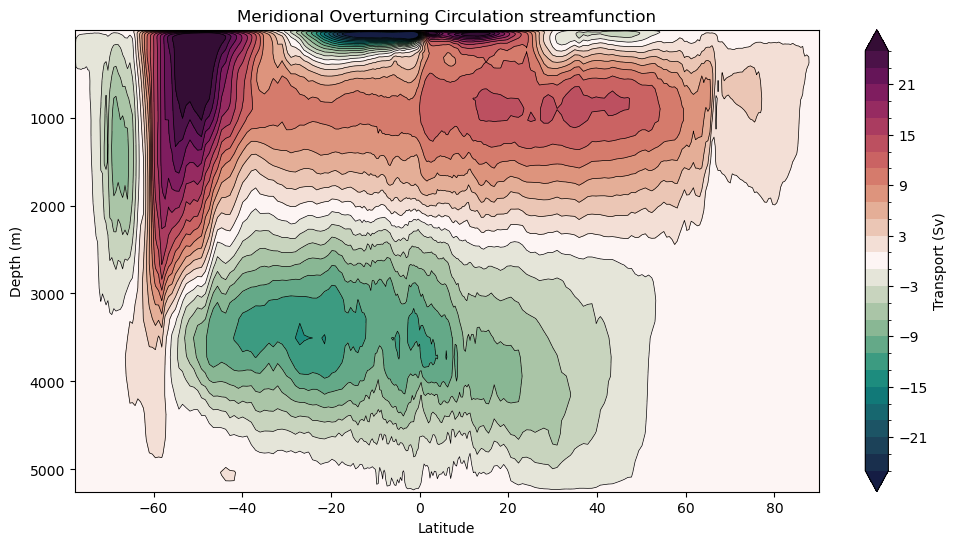

In [8]:
levels =  np.hstack((np.arange(-25, 0, 2), np.flip(-np.arange(-25, 0, 2))))
cbarticks = np.hstack((np.flip(-np.arange(3, 25, 6)), np.arange(3, 25, 6)))

plt.figure(figsize = (12, 6))
ψ.plot.contourf(levels = levels, cmap = cm.cm.curl, 
                cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ.plot.contour(levels = levels, colors = ['k'], linewidths = [0.5])
plt.ylabel('Depth (m)')
plt.xlabel('Latitude');
plt.gca().invert_yaxis();
plt.title('Meridional Overturning Circulation streamfunction');

#### Question 1

Describe the direction of the circulation in each of these areas, remembering that $T_y = \frac{\partial \psi}{\partial z}$. So, as you go deeper, $\partial z$ is negative - look at the sign of $\partial \psi$. Can you identify the abyssal cell? There is something strange... can you identify what it is?

*Answer here*

## Correcting the calculation

The MOC is a density driven circulation, which is best represented by looking at transport along equal density surfaces, called isopycnals. When we are working in depth space like before, and we integrate, if the overturning where to happen at varying depths depending on the location, it could average out. Let's illustrate this by plotting the depth of the 1037 kg/m$^3$ isopycnal:

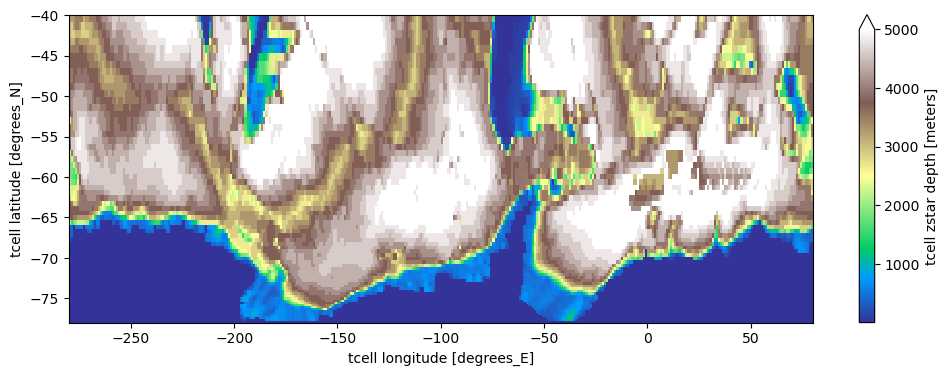

In [9]:
σ2 = xr.open_dataset('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class6/data/access-om2_pot_rho_2_iaf.nc')
σ2 = σ2['pot_rho_2'].sel(yt_ocean = slice(None, -40))

difference = np.abs(σ2 - 1037.2)
depth_index = difference.argmin('st_ocean', skipna = False)

σ2['st_ocean'][depth_index].plot(figsize = (12,4), vmax = 5000, cmap = 'terrain')

As you can see, there are variations of around 2000m in the depth of this isopycnal. A workaround used widely is to then calculate the overturning in *density* coordinates. Instead of having a vertical coordinate of depths, we will have one of potential density ($\sigma_2$, or `potrho`):

In [10]:
Ty_rho = xr.open_dataset('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class6/data/access-om2_ty_trans_rho_iaf.nc')

In [11]:
Ty_rho

<xarray.Dataset> Size: 35MB
Dimensions:        (potrho: 80, grid_xt_ocean: 360, grid_yu_ocean: 300)
Coordinates:
  * potrho         (potrho) float64 640B 1.028e+03 1.028e+03 ... 1.038e+03
  * grid_xt_ocean  (grid_xt_ocean) float64 3kB -279.5 -278.5 ... 78.5 79.5
  * grid_yu_ocean  (grid_yu_ocean) float64 2kB -77.75 -77.51 ... 89.55 90.0
Data variables:
    ty_trans_rho   (potrho, grid_yu_ocean, grid_xt_ocean) float32 35MB ...

Now instead of `st_ocean`, we have `potrho`. Note also that the horizontal dimensions now have a `grid_` appended at the beginning - models are annoying like that. It is the same dimensions as without the `grid_`, so no worries.

Let's repeat all the previous steps to get a transport, but replacing the dimension names:

In [12]:
Ty_rho = Ty_rho / (1035*1e6)

In [13]:
Ty_rho_int_x = Ty_rho['ty_trans_rho'].sum('grid_xt_ocean')

In [14]:
Ty_rho_int_x

<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 300)> Size: 96kB
array([[ 0.        ,  0.        ,  0.        , ..., -0.02760635,
        -0.02706919, -0.00439904],
       [ 0.        ,  0.        ,  0.        , ..., -0.00040808,
        -0.00031802,  0.00010841],
       [ 0.        ,  0.        ,  0.        , ..., -0.00033958,
        -0.00013963,  0.00011165],
       ...,
       [ 0.        , -0.00024459,  0.00012629, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 640B 1.028e+03 1.028e+03 ... 1.038e+03
  * grid_yu_ocean  (grid_yu_ocean) float64 2kB -77.75 -77.51 ... 89.55 90.0

In [15]:
ψ_rho = Ty_rho_int_x.cumsum('potrho') 

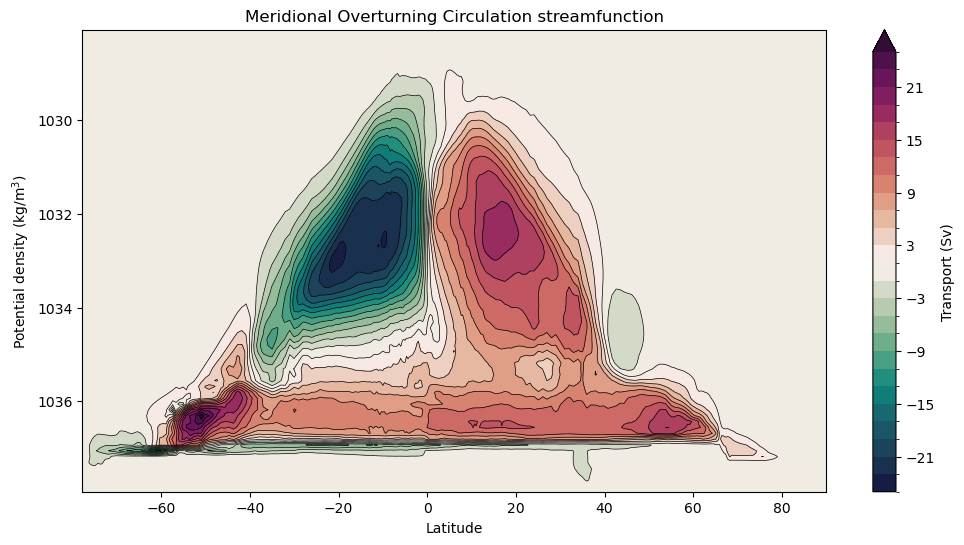

In [16]:
plt.figure(figsize = (12, 6))
ψ_rho.plot.contourf(levels = levels, cmap = cm.cm.curl, 
                cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ_rho.plot.contour(levels = levels, colors = ['k'], linewidths = [0.5])
plt.ylabel('Potential density (kg/m$^3$)')
plt.xlabel('Latitude');
plt.gca().invert_yaxis();
plt.title('Meridional Overturning Circulation streamfunction');

Let's plot both methods side by side:

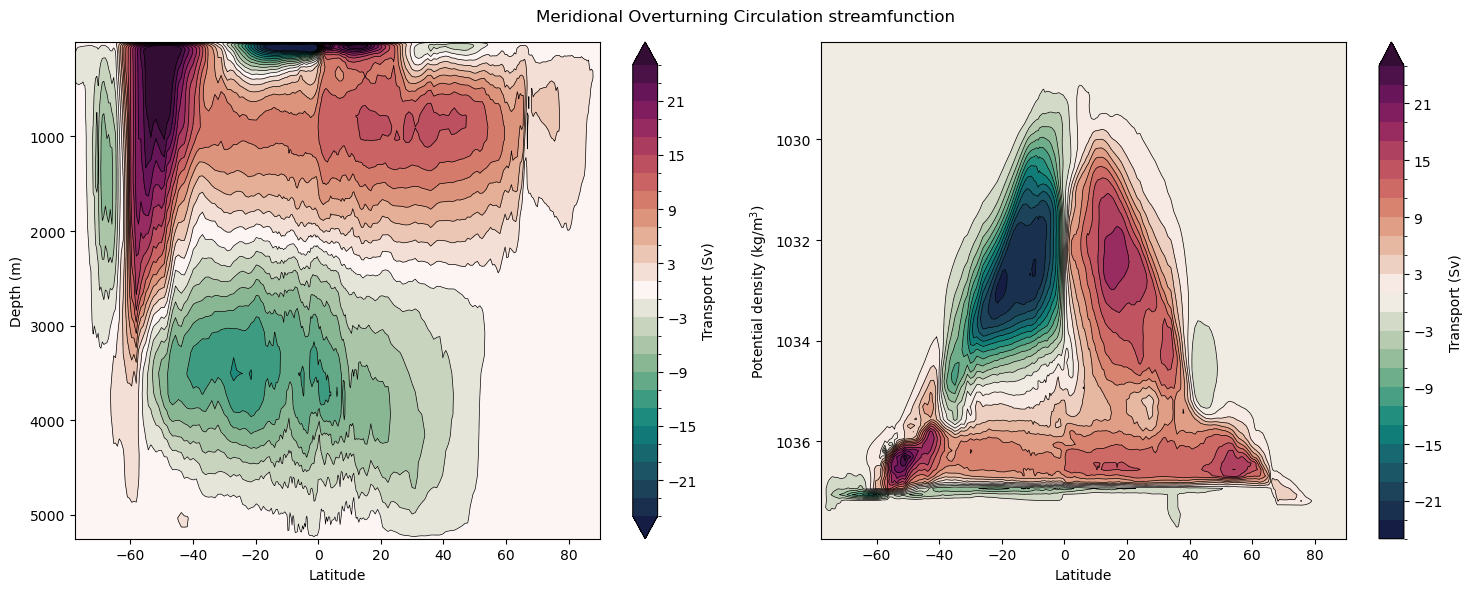

In [17]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6))
ψ.plot.contourf(ax = axs[0], levels = levels, cmap = cm.cm.curl, 
                    cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ.plot.contour(ax = axs[0], levels = levels, colors = ['k'], linewidths = [0.5])
axs[0].set_ylabel('Depth (m)')
ψ_rho.plot.contourf(ax = axs[1], levels = levels, cmap = cm.cm.curl, 
                    cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ_rho.plot.contour(ax = axs[1], levels = levels, colors = ['k'], linewidths = [0.5])
axs[1].set_ylabel('Potential density (kg/m$^3$)')
for ax in axs:
    ax.set_xlabel('Latitude');
    ax.invert_yaxis();
fig.suptitle('Meridional Overturning Circulation streamfunction');
plt.tight_layout();

They look very different! When we switch to density coordinates, we loose the ability to visualise really how *much* of the water column these cells are occupying. The two surface cells that are clearly very small in depth coordinates, become dominant in density coordinates. This is because they span a wide range of densities, not because they take up a lot of space.

Conversely, the abyssal cell that occupied such a big portion of the water column in depth coordinates, now is squished down at the bottom, since it is a cell that involves little density changes! So, the first takeaway is:

1. Don't associate the size of the cell in density coordinates to the amount of space it takes in the ocean.

Let's zoom in the abyssal and intermediate cells in density coordinates:

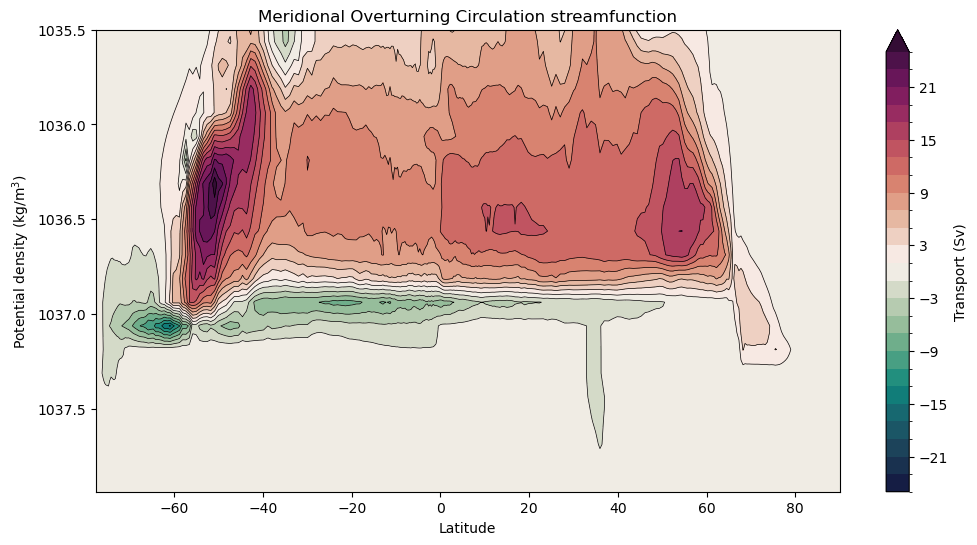

In [18]:
plt.figure(figsize = (12, 6))
ψ_rho.plot.contourf(levels = levels, cmap = cm.cm.curl, 
                cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ_rho.plot.contour(levels = levels, colors = ['k'], linewidths = [0.5])
plt.ylabel('Potential density (kg/m$^3$)')
plt.xlabel('Latitude');
plt.gca().invert_yaxis();
plt.ylim(None, 1035.5);
plt.title('Meridional Overturning Circulation streamfunction');

#### Question 2

Describe the circulation in the plot above, and associated water masses.

*Answer here*

## Bonus: add the effects of eddies

Eddies occur in the ocean at small spatial and temporal scales but nonetheless have important and significant effects in the large scale, particularly in the MOC circulation. A 1$^{\circ}$ model does not have high enough resolution to solve them, specially in polar latitudes, so instead it *parametrises* them.

These means that the model uses a simplified mathematical expression, depending on parameters, that to some degree of accuracy represents the *effects* of eddies, not the eddies themselves. 

We can add to our calculation the effect on transport of eddies, and see how that changes our MOC streamfunction. Don't worry about the steps, look at the result.

In [19]:
Ty_rho_gm = xr.open_dataset('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class6/data/access-om2_ty_trans_rho_GM_iaf.nc')

Ty_rho_gm = Ty_rho_gm / (1035*1e6)
Ty_rho_gm_int_x = Ty_rho_gm['ty_trans_rho_gm'].sum('grid_xt_ocean')

ψ_rho_eddies = ψ_rho + Ty_rho_gm_int_x

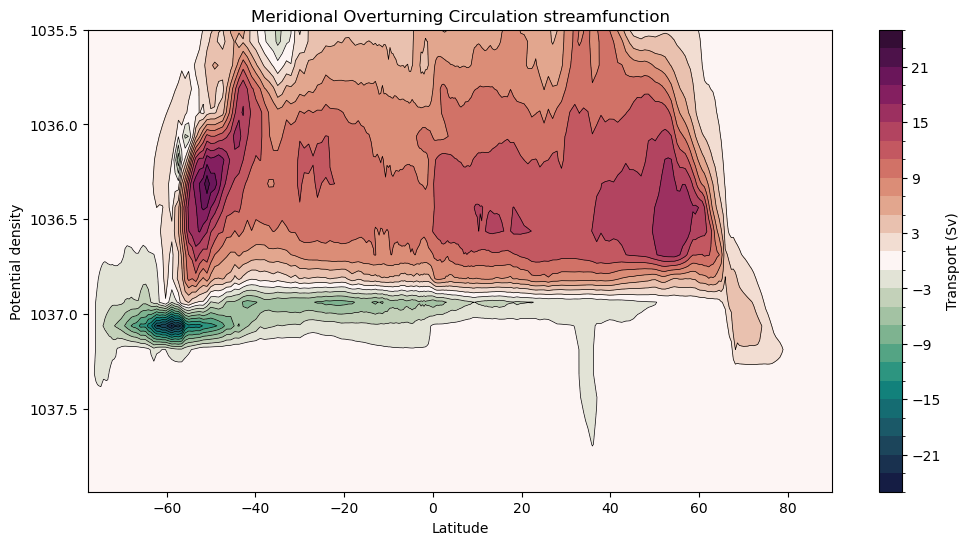

In [21]:
plt.figure(figsize = (12, 6))
ψ_rho_eddies.plot.contourf(levels = levels, cmap = cm.cm.curl, 
                cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ_rho_eddies.plot.contour(levels = levels, colors = ['k'], linewidths = [0.5])
plt.ylabel('Potential density')
plt.xlabel('Latitude');
plt.gca().invert_yaxis();
plt.ylim(None, 1035.5);
plt.title('Meridional Overturning Circulation streamfunction');

#### Question 3

Using the methods in `1_Transport_streamfunction.ipynb`, calculate the strength of the abyssal cell of the MOC, using the streamfunction in density coordinates. Compare the strength between the streamfunction with and without eddies.

*Answer here*